<center><h1> PDE: Higher Dimensional Sequential

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist
import dolfin as fin

In [2]:
from mud.plot import make_2d_unit_mesh
from mud.util import std_from_equipment

In [3]:
from experiments import mud_problem
from plotting import log_linear_regression, plot_experiment_measurements

In [4]:
from newpoisson import poisson, poisson_sensor_model
import pickle

In [5]:
from mud_problem import generate_sensors_pde, load_poisson

In [6]:
from experiments import experiment_measurements_index, extract_statistics_index
from plotting import log_linear_regression, plot_experiment_measurements

### Debugging: Implementation of Data-Driven Map

In [7]:
from scipy.stats import gaussian_kde as gkde

In [8]:
def ratio_dci(qoi):
    kde = gkde(qoi)
    ratio_eval = dist.norm.pdf(qoi)/kde.pdf(qoi)
    return ratio_eval

In [9]:
def meas_to_qoi(qoi, data, sd):
    if qoi.ndim == 1: qoi = qoi.reshape(1,-1)
    num_evals = qoi.shape[0]
    assert qoi.shape[1] == len(data)
    residuals = np.subtract(qoi, data)
    weighted_residuals = np.divide(residuals, sd)
    assert weighted_residuals.shape[0] == num_evals
    weighted_sum = np.sum(weighted_residuals, axis=1)
    return weighted_sum/np.sqrt(len(data))

In [10]:
def band_qoi(sensors, num_qoi=1, axis=1):
    intervals = np.linspace(0, 1, num_qoi+2)[1:-1]
    _intervals = np.array(intervals[1:]) + ( np.array(intervals[:-1]) - np.array(intervals[1:]) ) / 2
    _intervals = [0] + list(_intervals) + [1]
    qoi_indices = [np.where(np.logical_and(sensors[:, axis] > _intervals[i],
                                           sensors[:, axis] < _intervals[i+1]))[0] for i in range(num_qoi) ]
    return qoi_indices


def split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=None):
    qois = []
    if first is None: first = qoi.shape[1]
    for i in range(0, len(qoi_indices)):
        q = qoi_indices[i][qoi_indices[i] < first]
    #     q = qoi_indices[i]
        
        _qoi = qoi[:, q]
        _noise = noise[q]
        _data = np.array(qoi_true)[q] + _noise

        _newqoi = meas_to_qoi(_qoi, _data , sigma)
        qois.append(_newqoi)
    return qois


def ratio_dci_mult(qois):
    nq = np.array(qois)
    kde = gkde(nq)
    obs = dist.norm.pdf(nq)
    obs_eval = np.product(obs, axis=0)
    ratio_eval = np.divide(obs_eval, kde.pdf(nq))
    return ratio_eval

# Settings

In [11]:
from newpoisson import pcwExpr, pcwGFun

In [16]:
prefix      = f'pde-highd/pde-highd'
num_measure = 1000 # number of measurement (sensor) locations
fsize       = 32
num_trials  = 20   # realizations of synthetic data for numerical runs
tolerance   = 0.1 # precision of measurement equipment
sigma       = std_from_equipment(tolerance=tolerance, probability=0.99)
np.random.seed(21)
lam_true    = 3.0
input_dim   = 1
ftype       = 'png'

In [24]:
load = False
measurements = [20, 40, 60, 80, 100]
# tolerances = [1E-1, 1E-2, 1E-3]
print(f"Will run simulations for {measurements}")

Will run simulations for [20, 40, 60, 80, 100]


In [18]:
u = fin.Expression("-gamma*sin((2*kappa+1)*pi*x[0])", gamma=3.0, kappa=0.0, degree=3)
u = fin.Expression(f"pow(x[0], 2) * pow(x[0] - 1, 5) * gamma", gamma=lam_true*823543/12500, degree=3)
mesh = fin.UnitIntervalMesh(100)

def getVals(u,n):
    dx=1/(n+1)
    invals = [i*dx for i in range(n+2)]
    outvals = [u(i) for i in invals][1:-1]
    return invals[1:-1], outvals

def expressionNorm(u,v,n=100):
    u = getVals(u, n)[1] 
    v = getVals(v, n)[1]
    return np.linalg.norm(np.array(u) - np.array(v))/n

In [20]:
import glob

In [33]:
model_list = glob.glob(f'res{input_dim}u-data/*.xml')

# Define Sensors

In [25]:
sensors = generate_sensors_pde(num_measure)

In [26]:
qoi_true = poisson_sensor_model(sensors, gamma=lam_true, nx=36, ny=36)
noise = sigma*np.random.randn(num_measure)

### Visualize

In [27]:
p = poisson(gamma=lam_true, nx=36, ny=36)
V = p.function_space()

In [28]:
svals = [p(xi,yi) for xi,yi in sensors]

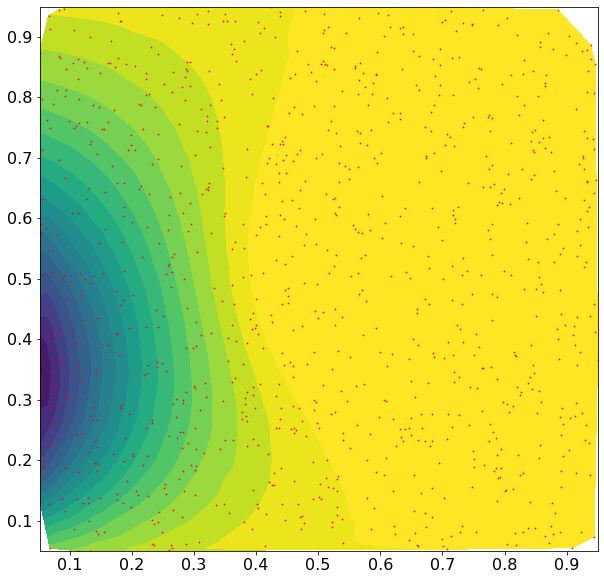

In [29]:
z = svals
x, y = sensors[:,0], sensors[:,1]
plt.tricontourf(x, y, z, levels=20, vmin=-0.5, vmax=0)
plt.scatter(x, y, c='r', s=0.5)
plt.show()

 ---

---

## Simulate Perturbed Response Surface

$\tau$ was specified in the cells above using `tolerance`, take a look at your possible data and determine if it is reasonable before proceeding.

In [30]:
pn = poisson(gamma=lam_true)
v = np.array(pn.vector())
# v = p.compute_vertex_values()
pn.vector()[:] = v + sigma*np.random.randn(len(v))

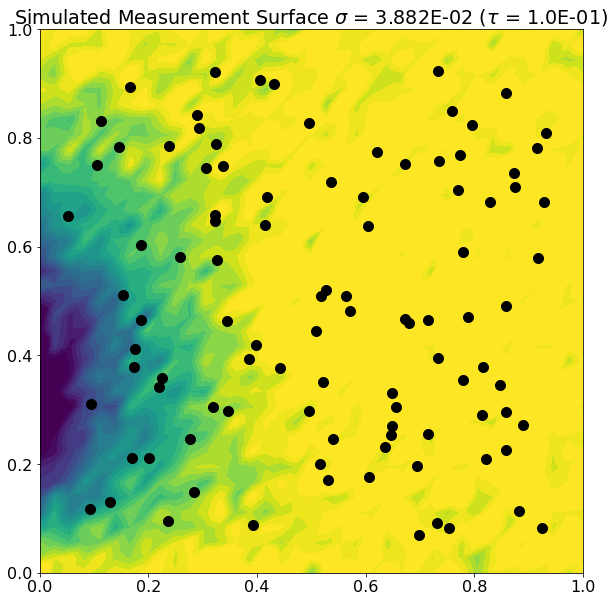

In [31]:
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface $\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
plt.scatter(sensors[0:100,0], sensors[0:100,1], s=100, c='k')
plt.show()

In [ ]:
# %%time
# model_list = model_dict[input_dim]
# lam, qoi = load_poisson(sensors, model_list, nx=36, ny=36)

In [ ]:
# domain = np.array([[-4,0]*input_dim]).reshape(-1,2)


In [34]:
intervals, gamma_true = getVals(u, input_dim)
w = fin.Expression(pcwExpr(u, input_dim, d=0), degree=2)
domain = np.array([[-4,0]*input_dim]).reshape(-1,2)

In [35]:
%%time
if load:
    fname = f'{prefix}_summary_{input_dim}.pkl'
    results = pickle.load(open(fname, 'rb'))
    solutions_sing, solutions_mult = results['sols']
    measurements = results['meas']
    noise, tolerance = results['noise']
    sigma = results['stdv']
    lam, qoi = results['sets']
    gamma_true, qoi_true = results['true']
    sensors = results['sens']
else:
    lam, qoi = load_poisson(sensors, model_list[0:1000], nx=36, ny=36)

Loaded 1000 evaluations of parameter space.


TypeError: string indices must be integers

## Best Case Scenario: Minimizing 2-Norms with Knowledge of Truth
minimizing norm of difference between "truth" and our samples, both input and output.

In [ ]:
%%time
closest_fit_index_in = np.argmin(np.linalg.norm(lam - np.array(gamma_true),axis=1))
closest_fit_index_out = np.argmin(np.linalg.norm(qoi - np.array(qoi_true) - noise,axis=1))

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
fin.plot(w, mesh=mesh, lw=5, c='k')
gt = list(lam[closest_fit_index_in, :])
plt.plot([0]+intervals+[1], [0]+gt+[0], lw=5, c='purple', alpha=1, label=f'Closest in Input: {closest_fit_index_in}')

projected_line = list(lam[closest_fit_index_out, :])
plt.plot([0]+intervals+[1], [0]+projected_line+[0], lw=5, c='green', alpha=1, label=f'Closest in Output: {closest_fit_index_out}')

plt.legend(fontsize=fsize*0.75)
plt.title(f'Parameter Space', fontsize=fsize*1.25)
plt.ylim(-4, 0)
plt.xlim(0, 1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)

plt.subplot(122)
_plot_num = max(measurements)
q = qoi[closest_fit_index_in,:]
plt.scatter(q[:_plot_num], qoi_true[:_plot_num] + noise[:_plot_num], c='purple', s=100, alpha=0.4, label=f'Closest in Input: {closest_fit_index_in}')
q = qoi[closest_fit_index_out,:]
plt.scatter(q[:_plot_num], qoi_true[:_plot_num] + noise[:_plot_num], c='green', s=100, alpha=0.4, label=f'Closest in Output: {closest_fit_index_out}')

_a = np.linspace(min(qoi_true),max(qoi_true), 2)
plt.plot(_a,_a, c='k', lw=3)
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5, 0.2)
# plt.legend(fontsize=fsize)
plt.xlabel('Predicted Data', fontsize=fsize)
plt.ylabel('Collected Data', fontsize=fsize)
plt.title("Q-Q Plot", fontsize=fsize*1.25)

# _fname = f"{prefix}_proj_D{input_dim}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

---

In [ ]:
num_qoi = input_dim
# plot_qoi = [20, 100, 500, 1000][::-1]
plot_qoi = measurements[::-2]
qoi_indices     = band_qoi(sensors, num_qoi, axis=1)
qoi_indices_bad = band_qoi(sensors, num_qoi, axis=0)
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']

In [ ]:
_intervals = np.array(intervals[1:]) + ( np.array(intervals[:-1]) - np.array(intervals[1:]) ) / 2

In [ ]:
plt.figure(figsize=(10,10))
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axhline(_intervals[i], lw=3, c='k')
    _q = qoi_indices[i][qoi_indices[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim, intervals, s=200, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

_fname = f"{prefix}_sensors_D{input_dim}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,10))
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title(f"Simulated Measurement Surface\n$\\sigma$ = {sigma:1.3E} ($\\tau$ = {tolerance:1.1E})")
for i in range(0, num_qoi):
    if i < num_qoi - 1: plt.axvline(_intervals[i], lw=3, c='k')
    _q = qoi_indices_bad[i][qoi_indices_bad[i] < 100 ]
    plt.scatter(sensors[_q,0], sensors[_q,1], s=100, color=colors[i%2])
plt.scatter([0]*input_dim,intervals, s=200, marker='^', c='w')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([])
plt.yticks([])
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$x_2$", fontsize=fsize)

_fname = f"{prefix}_sensors-alt_D{input_dim}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

# Geometry Study

In [ ]:
if input_dim == 2:
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green'][::-1]
#     plot_qoi = [20, 100, 500, 1000][::-1]
    for idx, _first in enumerate(plot_qoi):
        qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=_first)
        plt.scatter(qois[0], qois[1], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
    plt.legend()
    plt.title("Horizontal Band QoI", fontsize=1.25*fsize)
    plt.xlabel("$q_1$", fontsize=fsize)
    plt.ylabel("$q_2$", fontsize=fsize)
    
    plt.subplot(122)
    for idx, _first in enumerate(plot_qoi):
        qois = split_qoi_by_indices(qoi_indices_bad, qoi_true, qoi, noise, sigma, first=_first)
        plt.scatter(qois[0], qois[1], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
    plt.legend()
    plt.title("Vertical Band QoI", fontsize=1.25*fsize)
    plt.xlabel("$q^*_1$", fontsize=fsize)
    plt.ylabel("$q^*_2$", fontsize=fsize)

else:
    plt.figure(figsize=(20,20))
#     lim = 7.5/tolerance
    lim = 3/tolerance
    fig, axs = plt.subplots(input_dim, input_dim, figsize=(20,20))
    for _i in range(input_dim):
        for _j in range(_i, input_dim):
            if _i == _j:
                ax = axs[_i][_i]

                ax.annotate(f"$q{_i+1}$", (-lim/10,0), fontsize=fsize)
    #             ax.set_ylabel(f"$q{_i+1}$")
    #             ax.set_xlabel(f"$q{_i+1}$")
                ax.set_xlim(-lim, lim)
                ax.set_ylim(-lim, lim)
    #             ax.set_xticks([])
    #             ax.set_yticks([])
            else:
                for idx, _first in enumerate(plot_qoi):
                    ax = axs[_i][_j]
                    qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=_first)
                    ax.scatter(qois[_i], qois[_j], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
                    ax.set_xlim(-lim, lim)
                    ax.set_ylim(-lim, lim)
                    ax.set_xticks([])
                    ax.set_yticks([])

                    ax = axs[_j][_i]
                    qois = split_qoi_by_indices(qoi_indices_bad, qoi_true, qoi, noise, sigma, first=_first)
                    ax.scatter(qois[_i], qois[_j], label=f'First {_first}', s=20, c=colors[idx], alpha=1)
                    ax.set_xlim(-lim, lim)
                    ax.set_ylim(-lim, lim)
                    ax.set_xticks([])
                    ax.set_yticks([])

# _fname = f"{prefix}_geom_D{input_dim}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()    

# POC: Solve Inverse Problem

### Single QoI

In [ ]:
# noise = np.random.randn(num_measure)*sigma
num_meas_ex_sol = 100

In [ ]:
%%time
newqoi = meas_to_qoi(qoi[:,0:num_meas_ex_sol], qoi_true[0:num_meas_ex_sol] + noise[0:num_meas_ex_sol], sigma)
r_sing = ratio_dci(newqoi)

In [ ]:
mud_idx = np.argmax(r_sing)
mud_fun = lam[mud_idx,:]
print(mud_idx)

### Multiple QoI

In [ ]:
%%time
qois = split_qoi_by_indices(qoi_indices, qoi_true, qoi, noise, sigma, first=num_meas_ex_sol)
r_mult = ratio_dci_mult(qois)

In [ ]:
mud_idx_mult = np.argmax(r_mult)
mud_fun_mult = lam[mud_idx_mult,:]

In [ ]:
mud_idx_mult

## Compare Vector-Valued and Scalar Example Solutions

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(131)
fin.plot(poisson(mud_fun, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Scalar-Valued)', fontsize=1.25*fsize)

plt.subplot(132)
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title('(Noisy) Response Surface', fontsize=1.25*fsize)

plt.subplot(133)
fin.plot(poisson(mud_fun_mult, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Vector-Valued)', fontsize=1.25*fsize)

# _fname = f"{prefix}_surf_exmud_D{input_dim}_m{num_meas_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()


In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
fin.plot(u, mesh=mesh, lw=5, c='k')
fin.plot(w, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, label='Interpolant')
# fin.plot(w, mesh=mesh, lw=10, c='r', ls='-', alpha=0.5)
plt.scatter(intervals, gamma_true, marker='^', s=200, c='purple', zorder=10)
plt.title(f'Ex. MUD Solution, m={num_meas_ex_sol}', fontsize=1.25*fsize)

plt.plot(np.linspace(0,1,input_dim+2),
            [0] + list(mud_fun) + [0],
            alpha=0.5, c='r', lw=10, label=f'Scalar MUD, Sample {mud_idx}')

plt.plot(np.linspace(0,1,input_dim+2),
            [0] + list(mud_fun_mult) + [0],
            alpha=0.5, c='b', lw=10, label=f'Vector MUD, Sample {mud_idx_mult}')

plt.axvline(2/7, alpha=0.4, ls=':')
plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)
plt.legend(fontsize=fsize*0.75)

plt.subplot(122)
_data = qoi_true[:num_meas_ex_sol] + noise[:num_meas_ex_sol]
plt.scatter(qoi[mud_idx,:num_meas_ex_sol], _data, c='r', s=100, alpha=0.4, label=f'Scalar MUD, Sample {mud_idx}')
plt.scatter(qoi[mud_idx_mult,:num_meas_ex_sol], _data, c='b', s=100, alpha=0.4, label=f'Vector MUD, Sample {mud_idx_mult}')

_a = np.linspace(min(qoi_true) ,max(qoi_true), 2)
plt.plot(_a,_a, c='k', lw=3)
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5, 0.2)
plt.xlabel('Predicted Data', fontsize=fsize)
plt.ylabel('Collected Data', fontsize=fsize)
plt.title("Q-Q Plot", fontsize=fsize*1.25)
# plt.legend()


# _fname = f"{prefix}_comp_exmud_D{input_dim}_m{num_meas_ex_sol}.{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

In [ ]:
print(gamma_true)

In [ ]:
labels = ['Scalar QoI', 'Vector QoI']
plot_top = 1000
thresh = lam.shape[0]**-1
# thresh = 1E-16
colors = ['xkcd:red', 'xkcd:black', 'xkcd:orange', 'xkcd:blue', 'xkcd:green']
num_samps_ex_sol = 100

if input_dim == 2:
    for _i in range(input_dim):
        for _j in range(_i+1, input_dim):
            for idx, ratio_eval in enumerate([r_sing, r_mult]):
                _m = np.where(ratio_eval/max(ratio_eval) > thresh)[0]
#                 plt.scatter(lam[_m[101:5000], _i], lam[_m[101:5000], _j], c='orange', marker='^', alpha=0.2)
#                 plt.scatter(lam[_m[plot_top+1:1000], _i], lam[_m[plot_top+1:1000], _j], c='orange', marker='^', alpha=0.2)
                plt.scatter(lam[_m[:plot_top], _i], lam[_m[:plot_top], _j], c=colors[idx], label= labels[idx] + ' (Total %d)'%len(_m), s=20)
            plt.xlabel(f"$\lambda_{_i+1}$", fontsize=fsize)
            plt.ylabel(f"$\lambda_{_j+1}$", fontsize=fsize)
            plt.ylim(-4,0)
            plt.xlim(-4,0)
            plt.scatter(gamma_true[_i], gamma_true[_j], c='k', s=200, alpha=0.5, label='Interpolant', zorder=-10)
            plt.scatter(lam[closest_fit_index_out, _i], lam[closest_fit_index_out, _j], c='g', s=500, alpha=0.8, label='Projection', zorder=15)
            plt.legend()
            plt.title(f"Samples (m = {num_samps_ex_sol}) with\nRelative Ratio > {thresh:1.1E}", fontsize=fsize)

else:

    fig, axs = plt.subplots(input_dim, input_dim, figsize=(20,20))
    for _i in range(input_dim):
        for _j in range(_i, input_dim):
            if _i != _j:
                for idx, ratio_eval in enumerate([r_sing, r_mult]):
                    ax = axs[_j][_i] if not idx else axs[_i][_j]
                    _m = np.where(ratio_eval/max(ratio_eval) > thresh)[0]
                    ax.scatter(lam[_m[:plot_top], _i], lam[_m[:plot_top], _j], c=colors[2+idx], label= str(len(_m)) + ' ' + labels[idx], s=10)


    #                 ax.set_xlabel(f"$\lambda_{_i+1}$")
    #                 ax.set_ylabel(f"$\lambda_{_j+1}$")
                    ax.set_ylim(-4,0)
                    ax.set_xlim(-4,0)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.scatter(gamma_true[_i], gamma_true[_j], c='k', s=250, alpha=1, label='Interpolant', zorder=-10)
                    ax.scatter(lam[closest_fit_index_out, _i], lam[closest_fit_index_out, _j], c='g', s=400, alpha=0.5, label='Projection', zorder=-10)
    #                 ax.legend()
            else:
                ax = axs[_i][_i]
                ax.annotate(f"$\lambda_{_i+1}$", (-0.6,0.5), fontsize=fsize)
#                 ax.set_xlabel(f"$\lambda_{_i+1}$", fontsize=fsize)
#                 ax.set_ylabel(f"$\lambda_{_i+1}$", fontsize=fsize)

                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlim(-1,0)


_fname = f"{prefix}_update_scatter_D{input_dim}_t{thresh:1.1E}".replace('.', '-') + f".{ftype}"
# plt.savefig(_fname, bbox_inches='tight')
plt.show()

# Where From Here

We have solved the inverse problem for two knot points using two viable methods: the scalar- and vector-valued approaches for forming a QoI map.

Let us now use the figure above to inform how we can more intelligently improve our estimation of the function $g$.

We are not allowing ourselves to run any more experiments, we need to leverage our existing hundred measurements.

# Errors with `scipy.integrate.trapz`

In [ ]:
import scipy.integrate as integrate

In [ ]:
thresh_2d = 0.5
idx_sing = np.where(r_sing>thresh_2d)[0]
idx_mult = np.where(r_mult>thresh_2d)[0]

In [ ]:
L_2_error_initial = [ np.sqrt(integrate.trapz(np.abs(lam[r,:]-gamma_true)**2, x=intervals)) for r in range(lam.shape[0]) ]
L_2_error_sing = [ np.sqrt(integrate.trapz(np.abs(lam[r,:]-gamma_true)**2, x=intervals)) for r in idx_sing ]
L_2_error_mult = [ np.sqrt(integrate.trapz(np.abs(lam[r,:]-gamma_true)**2, x=intervals)) for r in idx_mult ]

In [ ]:
bins = np.linspace(min(L_2_error_initial), max(L_2_error_initial), 20)
plt.hist(L_2_error_initial, bins=bins, label=f"Initial Samples", color="black", density=True)
plt.hist(L_2_error_sing, bins=bins, label=f"SV Updated Samples", color="red", density=True, alpha=0.8)
plt.hist(L_2_error_mult, bins=bins, alpha=0.8, label=f"VV Updated Samples", color="blue", density=True)
plt.title(f"2 Dimensions: $L^2$ Error to $g$")
plt.legend()
plt.xlabel("Error")
_fname = f"{prefix}_hist_D{input_dim}_t{thresh_2d:1.1E}".replace('.', '-') + f".{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

## Pick out Vector-Valued Samples

In [ ]:
lam_mult = lam[idx_mult, :]
lam_sing = lam[idx_sing, :]

In [ ]:
_u, _s, _v = np.linalg.svd(lam_mult.T)
lam_mult_trans = (_u@lam_mult.T).T

_u, _s, _v = np.linalg.svd(lam_sing.T)
lam_mult_trans_sing = (_u@lam_mult.T).T

In [ ]:
plt.scatter(lam_mult_trans_sing[:,0], lam_mult_trans_sing[:,1])
plt.scatter(lam_mult_trans[:,0], lam_mult_trans[:,1])

The larger sample size of the scalar-valued approach is useful for identifying the singular vectors which we will leverage to transform uniform samples.

In [ ]:
_mn, _mx = np.min(lam_mult_trans_sing, axis=0), np.max(lam_mult_trans_sing, axis=0)

# form a uniform box and then rotate it using the U matrix from SVD
new_proposals_trans = np.random.rand(lam.shape[0],2)*(_mx-_mn) + _mn

In [ ]:
# %%time
new_proposals = (_u@new_proposals_trans.T).T

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.scatter(lam_mult_trans_sing[:,0], lam_mult_trans_sing[:,1])
plt.scatter(new_proposals_trans[:,0], new_proposals_trans[:,1], alpha=0.1)
plt.subplot(122)
plt.scatter(lam_mult[:,0], lam_mult[:,1])
plt.scatter(new_proposals[:,0], new_proposals[:,1], alpha=0.1)
plt.xlim(-4.25,0)
plt.ylim(-4,0.25)
plt.show()

We need to clean up those corners. So let's try something a little different.
Generate proposal samples from uniform, and transform them, keep the ones that
 - stay inside the parameter space
 - satisfy $\min_\lambda \lbrace || \lambda^* - \lambda ||^2_2 \rbrace \leq 0.01$
 
until 10,000 are generated. This requires no model evaluations and shouldn't take much time.

In [ ]:
%%time
# new_proposals_trans = np.random.rand(lam.shape[0]*2,2)*(_mx-_mn) + _mn
new_proposals_trans_trimmed = []
_count = 0
while _count < 1E4:
    _prop = np.random.rand(1,2)*(_mx-_mn) + _mn
    _prop = (_u@_prop.T).T
    _prop = _prop[0]
    if min(np.linalg.norm(_prop - lam_mult, axis=1)**2) < 0.05:
        if _prop[0] > -4 and _prop[0] < 0:
            if _prop[1] > -4 and _prop[1] < 0:
                new_proposals_trans_trimmed.append(_prop)
                _count += 1
new_proposals_trans_trimmed = np.array(new_proposals_trans_trimmed)

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(131)
plt.scatter(lam_mult[:,0], lam_mult[:,1])
plt.scatter(new_proposals[:,0], new_proposals[:,1], alpha=0.1)
plt.xlim(-4.25,0)
plt.ylim(-4,0.25)
plt.xlabel("$\lambda_1$", fontsize=fsize)
plt.ylabel("$\lambda_2$", fontsize=fsize)

plt.subplot(132)
plt.scatter(lam_mult_trans_sing[:,0], lam_mult_trans_sing[:,1])
plt.scatter(new_proposals_trans[:,0], new_proposals_trans[:,1], alpha=0.1)
# plt.xlabel("$\lambda^*_1$", fontsize=fsize)
# plt.ylabel("$\lambda^*_2$", fontsize=fsize)

plt.subplot(133)
plt.scatter(lam_mult[:,0], lam_mult[:,1])
plt.scatter(new_proposals_trans_trimmed[:,0], new_proposals_trans_trimmed[:,1], alpha=0.1)
plt.xlim(-4.25,0)
plt.ylim(-4,0.25)
plt.xlabel("$\lambda_1$", fontsize=fsize)
plt.ylabel("$\lambda_2$", fontsize=fsize)

_fname = f"{prefix}-alt_initial_D2_m{num_meas_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

## Next steps

We have now generated a suitable cover for the high-probability samples that came from solving the inverse problem with the vector-valued map.

We have three new knot points which we want to estimate. 
One happens to be in the middle of the two knots we estimated in the first problem. And we know two more values of $g$ from the Dirichlet boundary conditions on the top/bottom, so we can possibly bound these estimates as well.

Let us see how we can possibly generate a good set of proposal samples for this set by looking at the functions predicted by the accepted samples above.

In [ ]:
intervals_5d, gamma_true_5d = getVals(u, 5)
w_5d = fin.Expression(pcwExpr(u, 5, d=0), degree=2)

In [ ]:
plt.figure(figsize=(10,10))
plt.title(f'Predictions, m={num_meas_ex_sol} for 2D', fontsize=1.25*fsize)
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
# plt.plot([0]+intervals+[1], [0]+ [w(i) for i in intervals] +[0], lw=5, c='k')
# fin.plot(w_5d, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, label='Interpolant')

for i in range(lam_mult.shape[0]): # samples
    _lam = list(lam_mult[i,:])
    plt.plot([0]+intervals+[1], [0]+_lam+[0], lw=1, c='purple', alpha=0.2)
    # compute value at remaining knot points: will be derivable using midpoints since we use linears

_lam_mult = np.vstack([lam_mult[:,0],
                       (lam_mult[:,1] + lam_mult[:,0]),
                       lam_mult[:,1]])/2
lower_bounds = _lam_mult.min(axis=1)*1.2
upper_bounds = _lam_mult.max(axis=1)*0.8
print(lower_bounds, upper_bounds)
# gt = list(lam[closest_fit_index_out, :])
plt.ylim(-4, 0)
plt.xlim(0, 1)
for idx, _x in enumerate(np.linspace(0,1,7)[1:-1:2]):
    plt.axvline(_x)
    plt.vlines(_x, lower_bounds[idx], upper_bounds[idx],
               lw=20, color='orange', zorder=-1, alpha=1)
    plt.annotate(f'$\lambda_{idx*2+1}$', (_x, lower_bounds[idx] - 0.25))
# plt.legend()
_fname = f"{prefix}-alt_initial_D5_m{num_meas_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

For the sake of simplicity, we will just use the upper/lower bounds of the lines for each of the remaining knots.
The plot above is generated using the top 1000 samples from $\Lambda$, representing 10% of the original Monte-Carlo samples we used. To be a bit more conservative with our sampling, we will widen our intervals by an additional five percent above and below by multiplying by 0.95 and 1.05, respectively. (NOTE: be more conservative. go to 50%). 
We plot these bars in the same figure. (In reality, we didn't get 1000 samples, we got 926 based on our threshold of $1/N$).

In [ ]:
print(lower_bounds)
print(upper_bounds)

We now have bounds on our initial density in 5D. 
We will start with the 10,000 samples generated from our cover and append the three remaining directions in the appropriate order expected by the model:

In [ ]:
new_initial_2d = new_proposals_trans_trimmed
lb, ub = np.array(lower_bounds), np.array(upper_bounds)
new_initial_3d = np.random.rand(10000, 3)*(ub-lb) + lb

In [ ]:
new_initial = np.vstack([new_initial_3d[:,0],
                         new_initial_2d[:,0],
                         new_initial_3d[:,1],
                         new_initial_2d[:,1],
                         new_initial_3d[:,2]]).T
del new_initial_2d, new_initial_3d

# Initial Generated. Now let us sample our space.

In [ ]:
from newpoisson import poisson_sensor_model
from fenics import Point, RectangleMesh
surf_mesh = RectangleMesh(Point(0,0), Point(1,1), 36, 36)

In [ ]:
%%time
new_initial = new_initial[:1000,:]
new_qoi = []
for i in range(new_initial.shape[0]):
    new_qoi.append(poisson_sensor_model(sensors[:100,:], new_initial[i,:], nx=36, ny=36, mesh=surf_mesh))
new_qoi = np.array(new_qoi)

In [ ]:
new_initial.shape, new_qoi.shape

In [ ]:
pickle.dump({'sets': (new_initial, new_qoi), 'sens': sensors }, open('model_evals_5d-20percent.pkl', 'wb'))

# 5D: Solve Inverse Problem

### Single QoI

In [ ]:
%%time
newqoi_5d = meas_to_qoi(new_qoi[:,0:num_meas_ex_sol], qoi_true[0:num_meas_ex_sol] + noise[0:num_meas_ex_sol], sigma)
r_sing_5d = ratio_dci(newqoi_5d)

In [ ]:
mud_idx_5d = np.argmax(r_sing_5d)
mud_fun_5d = new_initial[mud_idx_5d,:]
print(mud_idx)

### Multiple QoI

In [ ]:
qoi_indices_5d = band_qoi(sensors, 5, axis=1)

In [ ]:
%%time
qois_5d = split_qoi_by_indices(qoi_indices_5d, qoi_true, new_qoi, noise, sigma, first=num_meas_ex_sol)
r_mult_5d = ratio_dci_mult(qois_5d)

In [ ]:
mud_idx_mult_5d = np.argmax(r_mult_5d)
mud_fun_mult_5d = new_initial[mud_idx_mult_5d,:]

In [ ]:
thresh_5d = 0.5
idx_mult_5d = np.where(r_mult_5d/max(r_mult_5d) > thresh_5d)[0]
# idx_mult_5d = np.argsort(r_mult_5d)[::-1]
lam_mult_5d = new_initial[idx_mult_5d, :]

In [ ]:
mud_idx_mult_5d

## Compare Vector-Valued and Scalar Example Solutions

In [ ]:
plt.figure(figsize=(30,10))

plt.subplot(131)
fin.plot(poisson(mud_fun_5d, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Scalar-Valued)', fontsize=1.25*fsize)

plt.subplot(132)
fin.plot(pn, vmin=-0.5, vmax=0)
plt.title('(Noisy) Response Surface', fontsize=1.25*fsize)

plt.subplot(133)
fin.plot(poisson(mud_fun_mult_5d, nx=36,ny=36), vmin=-0.5, vmax=0)
plt.title('MUD (Vector-Valued)', fontsize=1.25*fsize)

_fname = f"{prefix}_surf_exmud_D5-alt_m{num_meas_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()


In [ ]:
closest_fit_5d = np.argmin(np.linalg.norm(new_qoi - np.array(qoi_true)[:100] - noise[:100],axis=1))

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(121)
fin.plot(u, mesh=mesh, lw=5, c='k')
fin.plot(w_5d, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, label='Interpolant')
plt.plot(np.linspace(0,1,5+2),
         [0] + list(new_initial[closest_fit_5d,:]) + [0],
         label='Projection', lw=5, c='r')

# fin.plot(w, mesh=mesh, lw=10, c='r', ls='-', alpha=0.5)
plt.scatter(intervals_5d, gamma_true_5d, marker='^', s=200, c='purple', zorder=10)
plt.title(f'Ex. MUD Solution, m={num_meas_ex_sol}', fontsize=1.25*fsize)
1


plt.plot(np.linspace(0,1,5+2),
            [0] + list(mud_fun_5d) + [0],
            alpha=0.5, c='r', lw=10, label=f'Scalar MUD, Sample {mud_idx_5d}')

plt.plot(np.linspace(0,1,5+2),
            [0] + list(mud_fun_mult_5d) + [0],
            alpha=0.5, c='b', lw=10, label=f'Vector MUD, Sample {mud_idx_mult_5d}')

plt.axvline(2/7, alpha=0.4, ls=':')
plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.ylabel('$u(x, \lambda)$', fontsize=fsize)
plt.xlabel('$x_1$', fontsize=fsize)
plt.legend(fontsize=fsize*0.5)

plt.subplot(122)
_data = qoi_true[:num_meas_ex_sol] + noise[:num_meas_ex_sol]
plt.scatter(qoi[mud_idx_5d,:num_meas_ex_sol], _data, c='r', s=100, alpha=0.4, label=f'Scalar MUD, Sample {mud_idx_5d}')
plt.scatter(qoi[mud_idx_mult_5d,:num_meas_ex_sol], _data, c='b', s=100, alpha=0.4, label=f'Vector MUD, Sample {mud_idx_mult_5d}')

_a = np.linspace(min(qoi_true) ,max(qoi_true), 2)
plt.plot(_a,_a, c='k', lw=3)
plt.xlim(-0.5, 0.2)
plt.ylim(-0.5, 0.2)
plt.xlabel('Predicted Data', fontsize=fsize)
plt.ylabel('Collected Data', fontsize=fsize)
plt.title("Q-Q Plot", fontsize=fsize*1.25)
# plt.legend()


_fname = f"{prefix}-alt_comp_exmud_D5_m{num_meas_ex_sol}.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.title(f'Predictions, m={num_meas_ex_sol}', fontsize=1.25*fsize)
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
fin.plot(u, mesh=mesh, lw=5, c='k')
# fin.plot(w_5d, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, label='Interpolant')

for idx, _x in enumerate(np.linspace(0,1,7)[1:-1:2]):
    plt.axvline(_x)
    plt.vlines(_x, lower_bounds[idx], upper_bounds[idx],
               lw=20, color='orange', zorder=-1, alpha=0.4)

plt.plot(np.linspace(0,1,5+2),
         [0] + list(new_initial[closest_fit_5d,:]) + [0],
         label='Projection', lw=5, c='r', alpha=0.8)

plt.plot(np.linspace(0,1,5+2),
            [0] + list(mud_fun_mult_5d) + [0],
            alpha=0.5, c='b', lw=5, label=f'Vector MUD')

for i in range(lam_mult_5d.shape[0]): # samples
    _lam = list(lam_mult_5d[i,:])
    plt.plot([0]+intervals_5d+[1], [0]+_lam+[0], lw=1, c='purple', alpha=0.2)
    # compute value at remaining knot points: will be derivable using midpoints since we use linears

plt.ylim(-4, 0)
plt.xlim(0, 1)

plt.legend(fontsize=fsize)
plt.show()

---

In [ ]:
plt.figure(figsize=(10,10))

fin.plot(u, mesh=mesh, lw=5, c='k', label="$g$")
fin.plot(w_5d, mesh=mesh, lw=5, c='k', ls='--', alpha=0.5, zorder=0)
fin.plot(w_5d, mesh=mesh, lw=10, c='r', ls='-', alpha=0.5, label="$\hat{g}$", zorder=5)
plt.scatter(intervals_5d, gamma_true_5d, marker='^', s=200, c='purple', zorder=10)


for i in range(100):
    gt = new_initial[i,:]
    plt.plot([0]+intervals_5d+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
plt.title('Samples from Initial Density', fontsize=1.25*fsize)
plt.xlabel("$x_1$", fontsize=fsize)
plt.ylabel("$g(x, \lambda)$", fontsize=fsize)




# plt.axvline(2/7, alpha=0.4, ls=':')
# plt.axhline(-lam_true, alpha=0.4, ls=':')
plt.ylim(-4,0)
plt.xlim(0,1)
plt.legend()

_fname = f"{prefix}_init_D5-alt.{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

In [ ]:
L_2_error_initial_5d = [ np.sqrt(integrate.trapz(np.abs(new_initial[r,:]-gamma_true_5d)**2, x=intervals_5d)) for r in range(new_initial.shape[0]) ]
L_2_error_mult_5d = [ np.sqrt(integrate.trapz(np.abs(new_initial[r,:]-gamma_true_5d)**2, x=intervals_5d)) for r in idx_mult_5d[:100] ]

In [ ]:
np.sqrt(integrate.trapz(np.abs(new_initial[closest_fit_5d,:]-gamma_true_5d)**2, x=intervals_5d))

In [ ]:
bins = np.linspace(min(L_2_error_initial), max(L_2_error_initial), 20)
plt.hist(L_2_error_initial, bins=bins, label=f"Initial Samples, 2D", color="black", density=True)
plt.hist(L_2_error_initial_5d, bins=bins, label=f"Initial Samples, 5D", color="blue", density=True)
plt.hist(L_2_error_mult, bins=bins, alpha=0.8, label=f"VV Updated Samples, 2D", color="red", density=True)
plt.hist(L_2_error_mult_5d, bins=bins, alpha=0.8, label=f"VV Updated Samples, 5D", color="gray", density=True)
plt.legend()
plt.title(f"5 Dimensions: $L^2$ Error to $\lambda^\dagger$")
plt.xlabel("Error")
_fname = f"{prefix}_hist_D5_t{thresh_5d:1.1E}".replace('.', '-') + f".{ftype}"
plt.savefig(_fname, bbox_inches='tight')
plt.show()

## Set Up Experiments

In [ ]:
%%time
if input_dim == 11: measurements = [60, 80, 100]


# SCALAR
def mud_wrapper(num_obs, sd):
    newqoi = meas_to_qoi(qoi=new_qoi[:,0:num_obs], data=qoi_true[0:num_obs] + np.random.randn(num_obs)*sd, sd=sd)
    r_sing = ratio_dci(newqoi)
    return r_sing

experiments_sing, solutions_sing = experiment_measurements_index(num_measurements=measurements,
                                     sd=sigma,
                                     num_trials=num_trials,
                                     seed=21,
                                     fun=mud_wrapper)
# VECTOR
def mud_wrapper(num_obs, sd):
    qois = split_qoi_by_indices(qoi_indices_5d, qoi_true, new_qoi,
                                noise=np.random.randn(num_obs)*sd, sigma=sd, first=num_obs)
    r_mult = ratio_dci_mult(qois)
    return r_mult

experiments_mult, solutions_mult = experiment_measurements_index(num_measurements=measurements,
                                     sd=sigma,
                                     num_trials=num_trials,
                                     seed=21,
                                     fun=mud_wrapper)

del mud_wrapper

---

# The Story in Prediction Space

In [ ]:
if num_qoi == 1:
    solutions = solutions_sing
else:
    solutions = solutions_mult

In [ ]:
np.random.seed(21)
num_draws = 3
for idx in range(num_draws):
    i = np.random.randint(0,len(model_list))
    mudU = fin.Function(V, model_list[i][i]['u'])
    plt.subplot(int(f'{num_draws}{3}{1+3*idx}'))
    fin.plot(mudU, vmin=-0.5, vmax=0)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Rand#{idx}: {i}")
# plt.show()

num_plot_sensors = max(measurements)
for idx in range(num_draws):
#     _r = np.random.randint(0, num_trials)
    _r = idx
    i = solutions[num_plot_sensors][_r]
    mudU = fin.Function(V, model_list[i][i]['u'])
    plt.subplot(int(f'{num_draws}{3}{2+3*idx}'))
    fin.plot(mudU, vmin=-0.5, vmax=0)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"MUD#{idx}: {i}")

    q = qoi[i,:]
    plt.subplot(int(f'{num_draws}{3}{3+3*idx}'))
    plt.scatter(qoi_true + noise, q, c='b', s=50, alpha=0.05)
    plt.plot(_a,_a, c='k', lw=3)
#     plt.xlabel('True QoI (Noiseless)')
#     plt.ylabel('Predicted Signal')
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.5, 0.2)
    plt.ylim(-0.5, 0.2)
    plt.title(f"MUD#{idx}: {i}")

plt.show()

# p = poisson(3.0)
# fin.plot(p, mesh=mesh, vmin=-0.5, vmax=0)
# plt.title("True (Noiseless) Repsonse Surface")
# plt.show()

# The Story in Parameter Space

In [ ]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(20,10))
    
    plt.subplot(121)
    plt.title(f'MUD Parameters, m={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
    plt.plot([0]+intervals_5d+[1], [0]+ [w_5d(i) for i in intervals_5d] +[0], lw=5, c='k', label="Interpolant")
    for i in solutions_sing[num_plot_sensors]: # trials
        gt = new_initial[i,:]
        plt.plot([0]+intervals_5d+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
    gt = list(lam[closest_fit_index_out, :])
#     plt.plot([0]+intervals_5d+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label=f'Closest in Output: {closest_fit_index_out}')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend()
    plt.subplot(122)
    plt.title('Q-Q Plot', fontsize=1.25*fsize)
    for i in solutions_sing[num_plot_sensors]: # trials
        q = new_qoi[i,:]
        plt.scatter(q[:num_plot_sensors], qoi_true[:num_plot_sensors] + noise[:num_plot_sensors],
                    c='b', s=100, alpha=1.0/num_trials)
        plt.plot(_a,_a, c='k', lw=3)
        plt.ylabel('Collected Data', fontsize=fsize)
        plt.xlabel('Predicted Data', fontsize=fsize)
        plt.ylim(-0.5, 0.15)
        plt.xlim(-0.5, 0.15)
        #     plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_pair_D-alt-5-1_m{num_plot_sensors}.{ftype}"
    
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

In [ ]:
for num_plot_sensors in [20, 100]:
    plt.figure(figsize=(20,10))
    
    plt.subplot(121)
    plt.title(f'MUD Parameters, m={num_plot_sensors}', fontsize=1.25*fsize)
    plt.xlabel("$x_1$", fontsize=fsize)
    plt.ylabel("$g(x, \lambda)$", fontsize=fsize)
    plt.plot([0]+intervals_5d+[1], [0]+ [w_5d(i) for i in intervals_5d] +[0], lw=5, c='k', label="Interpolant")
    for i in solutions_mult[num_plot_sensors]: # trials
        gt = new_initial[i,:]
        plt.plot([0]+intervals_5d+[1], [0]+list(gt)+[0], lw=1, c='purple', alpha=0.2)
    gt = list(lam[closest_fit_index_out, :])
#     plt.plot([0]+intervals_5d+[1], [0]+gt+[0], lw=5, c='green', alpha=0.6, ls='--', label=f'Closest in Output: {closest_fit_index_out}')
    plt.ylim(-4, 0)
    plt.xlim(0, 1)
    plt.legend()
    plt.subplot(122)
    plt.title('Q-Q Plot', fontsize=1.25*fsize)
    for i in solutions_mult[num_plot_sensors]: # trials
        q = new_qoi[i,:]
        plt.scatter(q[:num_plot_sensors], qoi_true[:num_plot_sensors] + noise[:num_plot_sensors],
                    c='b', s=100, alpha=1.0/num_trials)
        plt.plot(_a,_a, c='k', lw=3)
        plt.ylabel('Collected Data', fontsize=fsize)
        plt.xlabel('Predicted Data', fontsize=fsize)
        plt.ylim(-0.5, 0.15)
        plt.xlim(-0.5, 0.15)
        #     plt.title(f'Solution {_r}, Index {_s}')
    _fname = f"{prefix}_pair_D-alt-5-5_m{num_plot_sensors}.{ftype}"
    
    plt.savefig(_fname, bbox_inches='tight')
    plt.show()

In [ ]:
if not load:
    print("Saving")
    fname = f'{prefix}_summary_5-alt.pkl'
    pickle.dump({'sets': (new_initial, new_qoi), 'sols': (solutions_sing, solutions_mult), 'meas': measurements, 'noise': (noise, tolerance), 'stdv': sigma, 'true': (gamma_true, qoi_true), 'sens': sensors }, open(fname, 'wb'))

---

---